In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from prophet import Prophet
from prophet.diagnostics  import cross_validation
from prophet.diagnostics import performance_metrics


# F&B Revenue Forecast Model

## Data

In [3]:
#import raw revenue data
df_2016 = pd.read_csv("../../raw_data/orders2016.csv", sep=";")
df_2017 = pd.read_csv("../../raw_data/orders2017.csv", sep=";")
df_2018 = pd.read_csv("../../raw_data/orders2018.csv", sep=";")
df_2019 = pd.read_csv("../../raw_data/orders2019.csv", sep=";")
df_2020 = pd.read_csv("../../raw_data/orders2020.csv", sep=";")
df_2021 = pd.read_csv("../../raw_data/orders2021.csv", sep=";")
df_2022 = pd.read_csv("../../raw_data/orders2022.csv", sep=";")

df_list = [df_2016, df_2017, df_2018, df_2019, df_2020, df_2021, df_2022]

#Dropping unnecessary columns, grouping by "date", summing "item_price" to get daily revenues

for i, df in enumerate(df_list):
    df_list[i] = pd.DataFrame(df.groupby(by="date")["item_price"].sum()/100)

#Concat all data in one dataframe, rename the columns for prophet

df = pd.concat(df_list, ignore_index=False)
df = df.rename(columns={"date": "ds", "item_price": "y"})
df["ds"] = df.index
df = df.reset_index(drop=True)
df = df[["ds","y"]]
df

#turning the ds (date) column into datetime

df['ds']=pd.to_datetime(df['ds'])

#Dropping outliers
df = df[df["y"]>=60]
df = df[df["y"]<=2300]
df = df.reset_index(drop=True)

In [4]:
#Loading additional regressor
feature_df = pd.read_csv("../../feature_data/final_feature_selection.csv")
feature_df["ds"] = pd.to_datetime(feature_df['ds'])

In [5]:
#Loading weather prediction data
weather_forecast = pd.read_csv("../../feature_data/finall_pred_weather.csv")
weather_forecast["ds"] = pd.to_datetime(weather_forecast["ds"])
weather_forecast["forecast dt iso"] = pd.to_datetime(weather_forecast["forecast dt iso"])

In [6]:
merged_df = pd.merge(df,feature_df,how="left")

## Predictions 

### Automated predictions for 2022 for evaluation purposes

In [ ]:
#regressors optimized in regards of performance and regularized

In [7]:
#Setting variables
horizon = 16
prediction_dates = ["2022-03-30","2022-04-09","2022-04-21","2022-05-01","2022-05-13","2022-05-25","2022-06-06","2022-06-18","2022-06-30",\
                   "2022-07-11","2022-07-23","2022-08-01","2022-08-13","2022-08-25","2022-09-02","2022-09-21","2022-10-02",\
                    "2022-10-14","2022-10-23","2022-11-05"]

# later days not working due to missing values in future holiday dataframe "2022-09-18" , "2022-09-06", ,"2022-09-30"]
predictions_mae = []
predictions_mape = []

#Looping through the dates to split into train and test set and make predictions

for date in prediction_dates:
    split_date = date
    index_split = df[df["ds"]==split_date].index[0]
    df_train = merged_df.iloc[:index_split]
    df_test = merged_df.iloc[index_split:]
    y_test = pd.DataFrame(df_test["y"])
    weather_index_split = weather_forecast[weather_forecast["forecast dt iso"]==split_date].index[0]
    weather_predict = weather_forecast.iloc[weather_index_split:weather_index_split+horizon,:]
    weather_predict = weather_predict.drop(columns="forecast dt iso")

    #Instantiate
    m = Prophet(changepoint_prior_scale = 0.1, seasonality_prior_scale = 0.1, seasonality_mode='multiplicative',\
           yearly_seasonality= 12, weekly_seasonality = True)

    #Adding regressors/features
    m.add_regressor("temp", prior_scale=5.0, mode="additive") 
    m.add_regressor("wind_speed", prior_scale=0.1, mode="additive")
    m.add_regressor("wind_deg", prior_scale=0.1, mode="additive")
    m.add_regressor("rain", prior_scale=0.5, mode="multiplicative")
    m.add_regressor("clouds", prior_scale=0.1, mode="additive")
    m.add_regressor("Holiday", prior_scale=0.1, mode="additive")
    m.add_regressor("inflation_rate", prior_scale=0.1, mode="multiplicative")

    #Fitting the model
    m = m.fit(df_train)
    
    #Creating future dataframe and adding features
    future = m.make_future_dataframe(periods=horizon)
    future = pd.merge(future,feature_df,how="left")
    
    #Update Future Timeframe with prediction weather data instead of historical weather data to prevent overfitting
    cols_to_update = ['temp', 'humidity', 'clouds', 'wind_speed', 'wind_deg', 'rain']
    future.loc[future.index[-(horizon):], cols_to_update] = weather_predict[cols_to_update].values
    
    #Predicting
    forecast = m.predict(future)
    seven_day_forecast = forecast.tail(horizon)
    seven_day_forecast_slim = seven_day_forecast[["ds","yhat_lower","yhat","yhat_upper"]]
    prediction_forecast = seven_day_forecast_slim
    prediction_forecast["y_true"] = y_test.head(horizon)
    prediction_forecast["error"]=prediction_forecast["yhat"]-prediction_forecast["y_true"]
    prediction_forecast["mae"]=abs(prediction_forecast["yhat"]-prediction_forecast["y_true"])
    prediction_forecast["mae_rolling"] = abs(prediction_forecast["error"]).rolling(window=len(prediction_forecast), min_periods=1).mean()
    prediction_forecast["mape"]=(abs((prediction_forecast["yhat"]/prediction_forecast["y_true"])-1)*100).round(2)
    prediction_forecast["mape_rolling"]= abs(prediction_forecast["mape"]).rolling(window=len(prediction_forecast), min_periods=1).mean()
    
    #Storing performance metrics
    predictions_mae.append(prediction_forecast["mae"].mean())
    predictions_mape.append(prediction_forecast["mape"].mean())

14:28:31 - cmdstanpy - INFO - Chain [1] start processing
14:28:31 - cmdstanpy - INFO - Chain [1] done processing
/tmp/ipykernel_1360/3853297727.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_forecast["y_true"] = y_test.head(horizon)
/tmp/ipykernel_1360/3853297727.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_forecast["error"]=prediction_forecast["yhat"]-prediction_forecast["y_true"]
/tmp/ipykernel_1360/3853297727.py:54: SettingWithCopyWarning: 
A value is trying to be set 

14:28:37 - cmdstanpy - INFO - Chain [1] done processing
/tmp/ipykernel_1360/3853297727.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_forecast["y_true"] = y_test.head(horizon)
/tmp/ipykernel_1360/3853297727.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_forecast["error"]=prediction_forecast["yhat"]-prediction_forecast["y_true"]
/tmp/ipykernel_1360/3853297727.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

14:28:41 - cmdstanpy - INFO - Chain [1] done processing
/tmp/ipykernel_1360/3853297727.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_forecast["y_true"] = y_test.head(horizon)
/tmp/ipykernel_1360/3853297727.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_forecast["error"]=prediction_forecast["yhat"]-prediction_forecast["y_true"]
/tmp/ipykernel_1360/3853297727.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

14:28:46 - cmdstanpy - INFO - Chain [1] done processing
/tmp/ipykernel_1360/3853297727.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_forecast["y_true"] = y_test.head(horizon)
/tmp/ipykernel_1360/3853297727.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_forecast["error"]=prediction_forecast["yhat"]-prediction_forecast["y_true"]
/tmp/ipykernel_1360/3853297727.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

14:28:51 - cmdstanpy - INFO - Chain [1] start processing
14:28:52 - cmdstanpy - INFO - Chain [1] done processing
/tmp/ipykernel_1360/3853297727.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_forecast["y_true"] = y_test.head(horizon)
/tmp/ipykernel_1360/3853297727.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_forecast["error"]=prediction_forecast["yhat"]-prediction_forecast["y_true"]
/tmp/ipykernel_1360/3853297727.py:54: SettingWithCopyWarning: 
A value is trying to be set 

In [8]:
#creating a dataframe with dates and performance metrics

performance_df = {"prediction_date":prediction_dates, "mae":predictions_mae, "mape":predictions_mape}
performance_df = pd.DataFrame(performance_df)
performance_df

,prediction_date,mae,mape
0,2022-03-30,229.037699,60.478750
1,2022-04-09,241.480612,40.195000
2,2022-04-21,320.047441,56.613750
3,2022-05-01,275.870579,35.637500
4,2022-05-13,202.786563,32.866250
5,2022-05-25,213.534382,44.413125
6,2022-06-06,165.862794,26.463125
7,2022-06-18,212.435221,25.157500
8,2022-06-30,147.852126,37.730625
9,2022-07-11,185.124533,31.958125


In [9]:
performance_df["mae"].mean()

191.83554862680018

In [10]:
performance_df["mape"].mean()

42.073562499999994

## Visualizing MAE & MAPE

In [ ]:
# MAE missing in legend and y axis need to be labeled

/tmp/ipykernel_444/80509004.py:2: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(performance_df['prediction_date'], rotation=45)


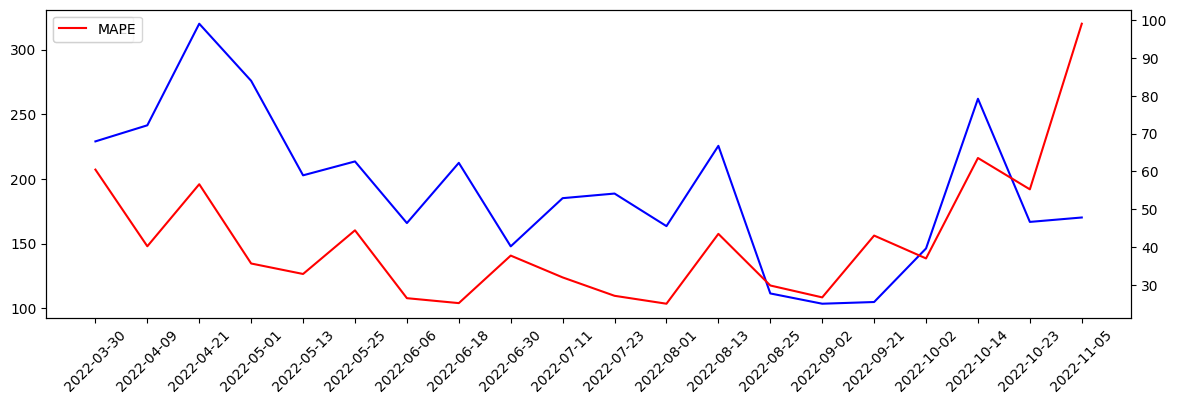

In [44]:
fig, ax1 = plt.subplots(figsize=(14,4))
ax1.set_xticklabels(performance_df['prediction_date'], rotation=45)
ax1.plot(performance_df['prediction_date'], performance_df['mae'], color="blue", label="MAE")
ax1.legend(loc='upper left')
ax2 = ax1.twinx()
ax2.plot(performance_df['prediction_date'], performance_df['mape'], color="red", label="MAPE")
plt.xlabel('Date')
plt.legend(loc='upper left')
plt.show()

### Saving prediction as csv

In [ ]:
#prediction_forecast.to_csv("output_data/baseline_prediction.csv")